In [ ]:
# Example of a Conditional Wasserstein GAN (CWGAN)
# Might be called W-C-DCGAN as it uses convolutions

In [ ]:
# https://jonathan-hui.medium.com/gan-a-comprehensive-review-into-the-gangsters-of-gans-part-1-95ff52455672
# https://lilianweng.github.io/lil-log/2017/08/20/from-GAN-to-WGAN.html
# https://machinelearningmastery.com/how-to-implement-wasserstein-loss-for-generative-adversarial-networks/

# https://www.tensorflow.org/tutorials/generative/dcgan

# https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/
# https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/

# https://machinelearningmastery.com/how-to-train-a-progressive-growing-gan-in-keras-for-synthesizing-faces/
# https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Dropout
from tensorflow.keras.layers import Reshape, Flatten, LeakyReLU, Embedding, Concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import plot_model

In [ ]:
# Constants
NROWS = 28
NCOLS = 28
NCHAN = 1

z_dim = 128
n_classes = 10

In [ ]:
# List of changes
# CH1: linear activation in the output of the critic.
# CH2: y = {-1, 1} for real images and fake images, respectively.
# CH3: Wasserstein loss to train the critic and generator models.
# CH4: Clip critic weights (-0.01, 0.01).
# CH5: Gaussian initializer of weights 0.0+-0.02
# CH6: Update critic 5x.
# CH7: RMSProp(lr=0.00005).
# CH8: Add noise to critic's input

In [ ]:
# CH3
def wasserstein_loss(y_true, y_hat):
  """
  Wasserstein loss function
  """
  return tf.keras.backend.mean(y_true * y_hat)

In [ ]:
# CH4
class ClipConstraint(Constraint):
  """
  Class implementation for clipping weights
  """
  # set clip value when initialized
  def __init__(self, clip_value):
    self.clip_value = clip_value

  # clip model weights to hypercube
  def __call__(self, weights):
    return tf.keras.backend.clip(weights, -self.clip_value, self.clip_value)

  # get the config
  def get_config(self):
    return {'clip_value': self.clip_value}

In [ ]:
# Sub model embedding
def create_embedding(n_classes, NROWS, NCOLS, NCHAN):
  const = ClipConstraint(0.01)     # CH4
  init = RandomNormal(stddev=0.02) # CH5

  model = Sequential()
  model.add(Input(shape=(1,)))
  model.add(Embedding(n_classes, NROWS * NCOLS * NCHAN, input_length=1))
  model.add(Flatten())
  model.add(Dense(NROWS * NCOLS * NCHAN, kernel_initializer=init, kernel_constraint=const))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((NROWS, NCOLS, NCHAN)))

  return model

Number of parameters: 623,280


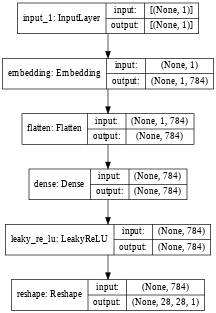

In [ ]:
embeder = create_embedding(n_classes, NROWS, NCOLS, NCHAN)
print(f"Number of parameters: {embeder.count_params():,}")
plot_model(embeder, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=48)

# Critic

In [ ]:
def create_critic(NROWS, NCOLS, NCHAN):
  const = ClipConstraint(0.01)     # CH4
  init = RandomNormal(stddev=0.02) # CH5

  model = Sequential()
  model.add(Input(shape=(NROWS, NCOLS, NCHAN + 1)))
  
  model.add(Conv2D(128, 3, strides=2, padding='same',
                   kernel_initializer=init,  # CH5
                   kernel_constraint=const)) # CH4
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, 3, strides=2, padding='same',
                   kernel_initializer=init,  # CH5
                   kernel_constraint=const)) # CH4
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, 3, strides=2, padding='same',
                   kernel_initializer=init,  # CH5
                   kernel_constraint=const)) # CH4
  model.add(LeakyReLU(alpha=0.2))

  model.add(Flatten())
  model.add(Dropout(0.3))
  model.add(Dense(1)) # CH1

  return model

Number of parameters: 299,649


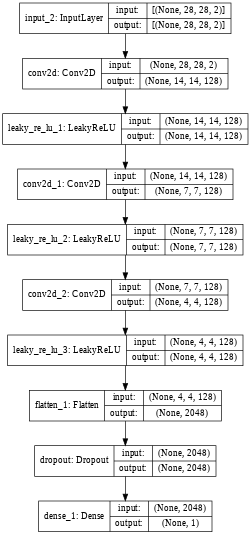

In [ ]:
crit = create_critic(NROWS, NCOLS, NCHAN)
print(f"Number of parameters: {crit.count_params():,}")
plot_model(crit, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=48)

In [ ]:
def create_ccritic(NROWS, NCOLS, NCHAN, n_classes):
  img = Input(shape=(NROWS, NCOLS, NCHAN), name='x_INPUT')

  #n = tf.random.uniform(shape=(NROWS, NCOLS, NCHAN), minval=-0.05, maxval=0.05) # CH 8
  n = tf.random.normal(shape=(NROWS, NCOLS, NCHAN), mean=0.0, stddev=0.1) # CH 8
  img_noise = tf.math.add(img, n) # CH 8

  c = Input(shape=(1, ), name='c_INPUT')
  c_embedding = Embedding(n_classes, NROWS * NCOLS * NCHAN, input_length=1)(c)
  c_embedding = Reshape((NROWS, NCOLS, NCHAN))(c_embedding)

  #embeder = create_embedding(n_classes, NROWS, NCOLS, NCHAN)
  #c_embedding = embeder(c) # CH 9
  #c_embedding = Reshape((NROWS, NCOLS, NCHAN))(c_embedding)

  concatenated = Concatenate(axis=-1)([img_noise, c_embedding]) # CH 8

  critic = create_critic(NROWS, NCOLS, NCHAN)
  y = critic(concatenated)

  # Model
  model = Model([img, c], y)
  model.compile(loss=wasserstein_loss, # CH3
                optimizer=RMSprop(lr=0.00005), # CH 7
                metrics=['accuracy'])

  return model

Number of parameters: 307,489


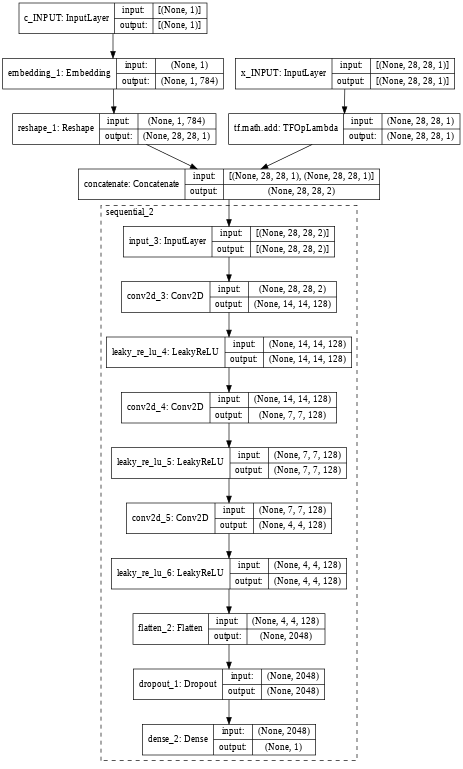

In [ ]:
ccrit = create_ccritic(NROWS, NCOLS, NCHAN, 10)
print(f"Number of parameters: {ccrit.count_params():,}")
plot_model(ccrit, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=48)

# Generator

In [ ]:
def create_generator(z_dim):
  init = RandomNormal(stddev=0.02)

  model = Sequential()
  model.add(Input(shape=(4, 4, z_dim + 1)))

  model.add(Conv2DTranspose(128, 4, strides=2, padding='same', kernel_initializer=init)) # CH5
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(128, 4, strides=2, padding='same', kernel_initializer=init)) # CH5
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, 3, kernel_initializer=init)) # CH5
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(128, 4, strides=2, padding='same', kernel_initializer=init)) # CH5
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(1, 7, padding='same', activation='tanh', kernel_initializer=init)) # CH5

  return model

Number of parameters: 942,721


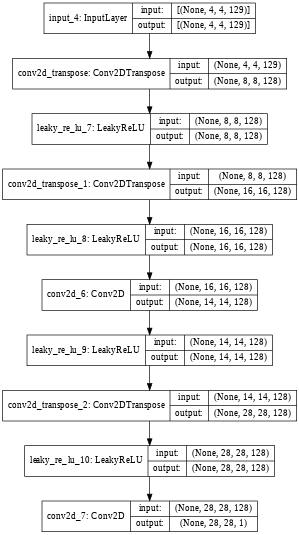

In [ ]:
gene = create_generator(z_dim)
print(f"Number of parameters: {gene.count_params():,}")
plot_model(gene, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=48)

In [ ]:
def create_cgenerator(z_dim, n_classes):
  init = RandomNormal(stddev=0.02)

  z_in = Input(shape=(z_dim, ), name='z_INPUT')
  z = Dense(4 * 4 * z_dim, kernel_initializer=init)(z_in) # CH5
  z = LeakyReLU(0.2)(z)
  z = Reshape((4, 4, z_dim))(z)

  c_in = Input(shape=(1, ), name='c_INPUT')
  c = Embedding(n_classes, z_dim, input_length=1)(c_in)
  c = Dense(4 * 4)(c)
  c = Reshape((4, 4, 1))(c)
  #embeder = create_embedding(n_classes, 4, 4, 1)
  #c = embeder(c_in)

  concatenated = Concatenate(axis=-1)([z, c])

  generator = create_generator(z_dim)
  c_img = generator(concatenated) # x_hat

  return Model([z_in, c_in], c_img)

Number of parameters: 1,210,257


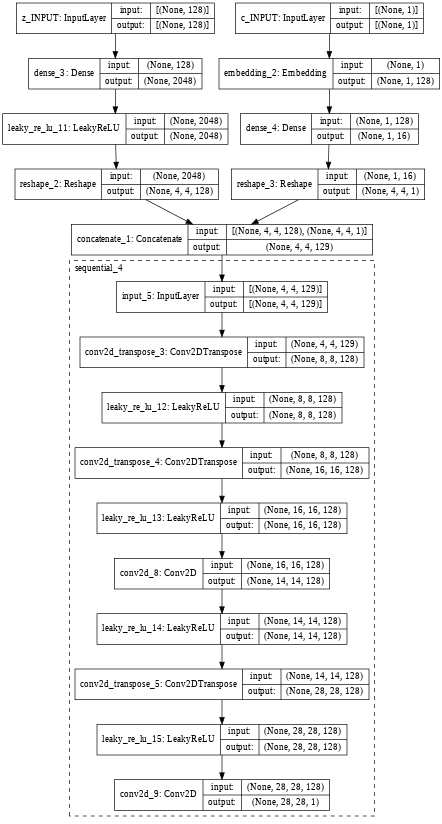

In [ ]:
cgene = create_cgenerator(z_dim, n_classes)
print(f"Number of parameters: {cgene.count_params():,}")
plot_model(cgene, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=48)

In [ ]:
del crit, ccrit, gene, cgene, #embeder

# Full CGAN

In [ ]:
def create_cgan(cgenerator, ccritic):
  ccritic.trainable = False

  gen_noise, gen_context = cgenerator.input #(None, 128) and (None, 1)
  gen_output = cgenerator.output #(None, 28, 28, 1)
  
  gan_output = ccritic([gen_output, gen_context])
  
  model = Model([gen_noise, gen_context], gan_output)
  model.compile(loss=wasserstein_loss, # CH3
                optimizer=RMSprop(lr=0.00005)) # CH7
  
  return model

Number of parameters: 1,517,746


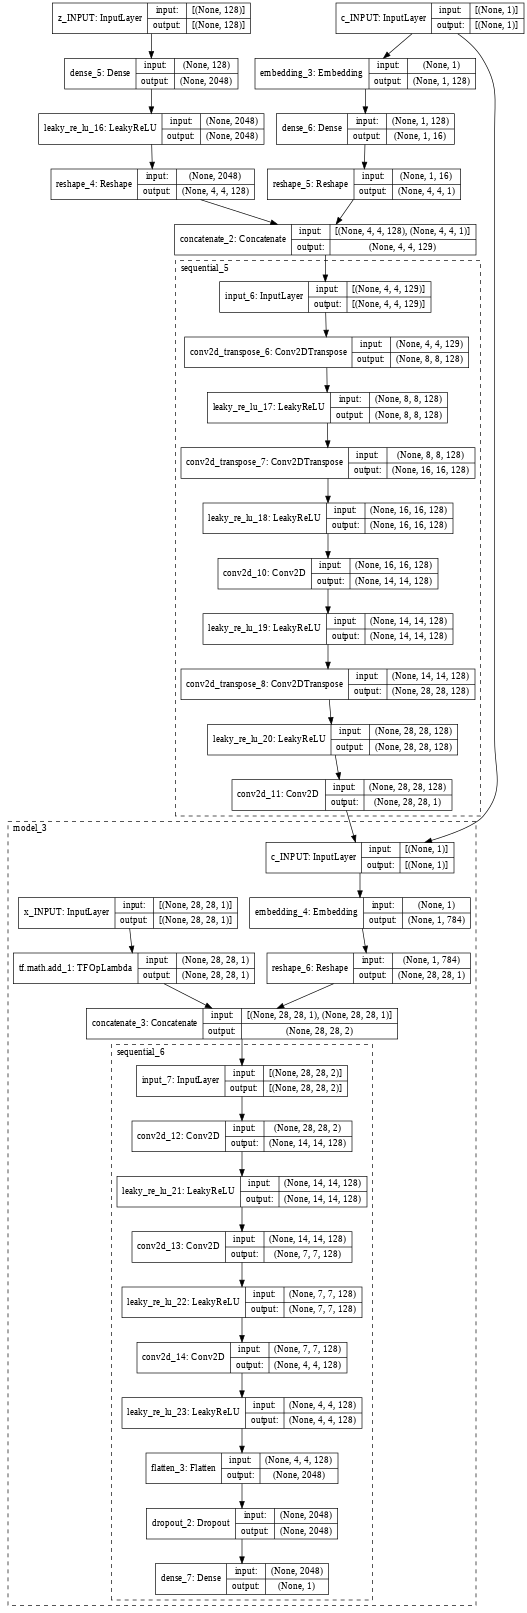

In [ ]:
cgene = create_cgenerator(z_dim, n_classes)
ccrit = create_ccritic(NROWS, NCOLS, NCHAN, 10)
WCGAN = create_cgan(cgene, ccrit)
print(f"Number of parameters: {WCGAN.count_params():,}")
plot_model(WCGAN, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=48)

In [ ]:
def train(X, c, params):
  # Unzip parameters
  n_epochs = params['n_epochs']
  batch_size = params['batch_size']
  sample_interval = params['sample_interval']
  z_dim = params['z_dim']
  n_classes = params['n_classes']

  # Get average image per class, as reference
  average_X = average_class(X, c)

  # Performance storage
  accuracies = []
  losses = []

  # Labels for real and fake images
  real = -np.ones((batch_size, 1)) # CH2
  fake = np.ones((batch_size, 1))  # CH2

  for epoch in range(n_epochs + 1):
    start_time = time.time()

    # -- Train Critic
    for _ in range(5): # CH6
      # Get a random batch of real images and their labels
      idx = np.random.randint(0, X.shape[0], batch_size)
      imgs, contexts = X[idx], c[idx]

      # Generate a batch of fake images
      z = np.random.normal(0, 1, (batch_size, z_dim))
      gen_imgs = cgene.predict([z, contexts])

      # Training
      d_loss_real = ccrit.train_on_batch([imgs, contexts], real)
      d_loss_fake = ccrit.train_on_batch([gen_imgs, contexts], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # -- Train Generator
    # Generate a batch of noise vectors and get a batch of random labels
    z = np.random.normal(0, 1, (batch_size, z_dim))
    contexts = np.random.randint(0, n_classes, batch_size).reshape(-1, 1)

    # Training
    g_loss = WCGAN.train_on_batch([z, contexts], real)
    elapsed_time = (time.time() - start_time)

    # -- Sample and print performance
    if (epoch % sample_interval) == 0:
      # Plot and return sample of generated images. Compute mae
      sampled_images = sample_images(z_dim)
      mae = np.abs(sampled_images - average_X).mean()
      print("%d [D loss: %.4f, acc.: %.2f%%] [G loss: %.4f, mae.: %.2f], in: %.2f seconds." % (epoch, d_loss[0], 100 * d_loss[1], g_loss, mae, elapsed_time))

      # Save losses and accuracies so they can be plotted after training
      losses.append((d_loss[0], g_loss))
      accuracies.append((d_loss[1], mae))

  return losses, accuracies

In [ ]:
def average_class(X, y):
  """ Given a set of images and their class labels, compute the average image
  per class. Use it as reference to estimate the error for a set of synthetic images.
  """
  classes = np.unique(y)
  av_cl = []
  for cl in classes:
    av_cl.append(X[y == cl].mean(axis=0))
  return np.array(av_cl)

In [ ]:
def sample_images(z_dim, plot_rows=2, plot_cols=5):
  z = np.random.normal(0, 1, (plot_rows * plot_cols, z_dim))
  labels = np.arange(0, 10).reshape(-1, 1)

  # Generate images from random noise
  gen_imgs_temp = cgene.predict([z, labels])
  gen_imgs = 0.5 * gen_imgs_temp + 0.5

  ind = 0
  fig, axs = plt.subplots(plot_rows, plot_cols, figsize=(10, 4), sharey=True, sharex=True)
  for row in range(plot_rows):
    for col in range(plot_cols):
      axs[row, col].imshow(gen_imgs[ind, :, :, 0], cmap='gray')
      axs[row, col].axis('off')
      axs[row, col].set_title("Digit: %d" % labels[ind])
      ind += 1
  plt.show()

  return gen_imgs_temp

In [ ]:
# Load data
(x_train, y_train), (_, _) = mnist.load_data()

# Rescale [0, 255] grayscale pixel values to [-1, 1]
x_train = x_train / 127.5 - 1.
x_train = np.expand_dims(x_train, axis=3)

# Turn into float32
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

print(x_train.shape)
print(y_train.shape)

(60000, 28, 28, 1)
(60000,)


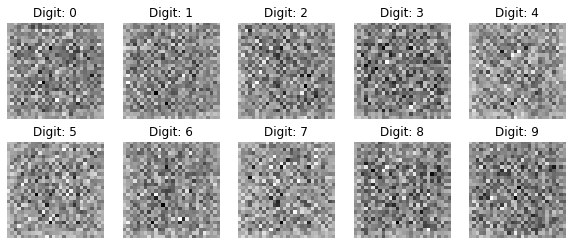

0 [D loss: -0.0031, acc.: 0.00%] [G loss: 0.0000, mae.: 0.78], in: 5.03 seconds.


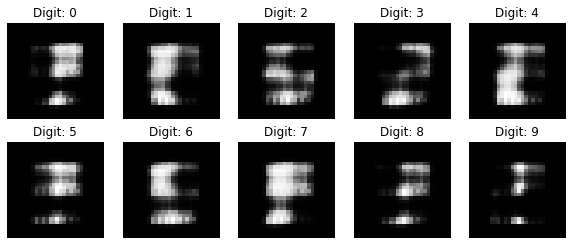

1000 [D loss: 1.0688, acc.: 50.00%] [G loss: -134.4528, mae.: 0.22], in: 0.40 seconds.


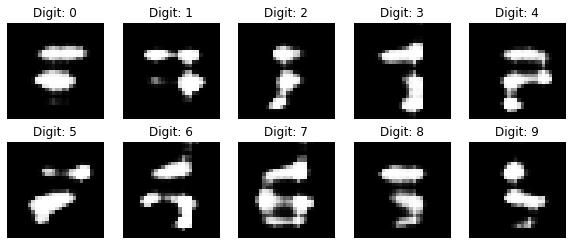

2000 [D loss: 0.8683, acc.: 50.00%] [G loss: -43.4993, mae.: 0.30], in: 0.39 seconds.


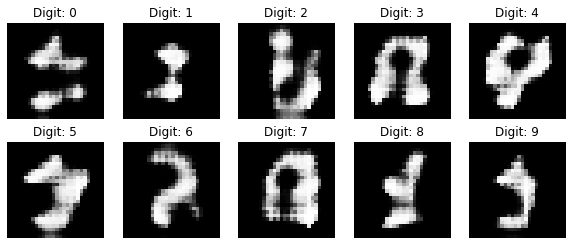

3000 [D loss: 0.0255, acc.: 50.00%] [G loss: -11.1040, mae.: 0.30], in: 0.39 seconds.


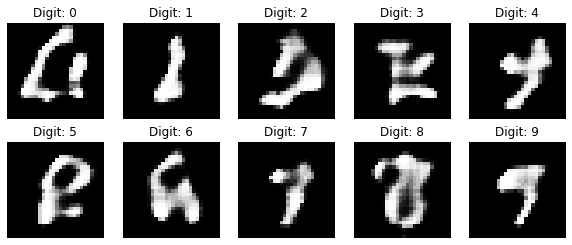

4000 [D loss: -0.0268, acc.: 50.00%] [G loss: -3.3468, mae.: 0.25], in: 0.42 seconds.


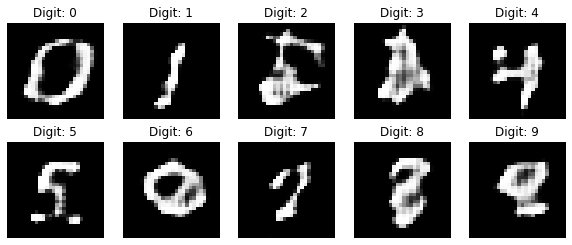

5000 [D loss: -0.0640, acc.: 50.00%] [G loss: -2.7407, mae.: 0.24], in: 0.40 seconds.


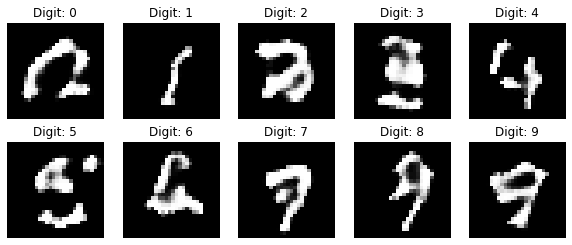

6000 [D loss: -0.0825, acc.: 50.00%] [G loss: -2.4929, mae.: 0.25], in: 0.39 seconds.


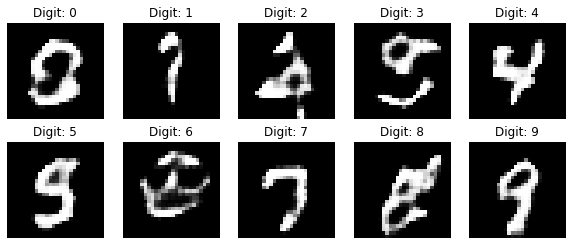

7000 [D loss: -0.0674, acc.: 50.00%] [G loss: -2.3538, mae.: 0.24], in: 0.39 seconds.


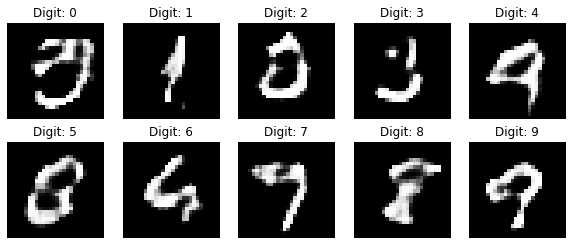

8000 [D loss: -0.1104, acc.: 50.00%] [G loss: -2.2800, mae.: 0.24], in: 0.39 seconds.


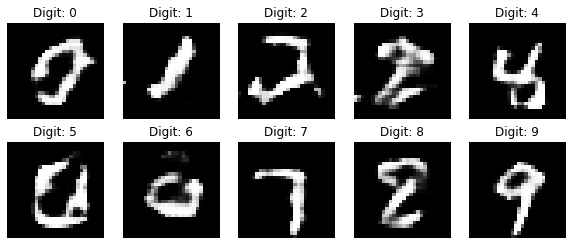

9000 [D loss: -0.1005, acc.: 50.00%] [G loss: -2.0501, mae.: 0.24], in: 0.37 seconds.


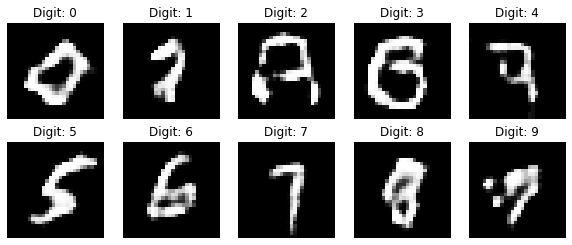

10000 [D loss: -0.0565, acc.: 50.00%] [G loss: -2.0754, mae.: 0.25], in: 0.38 seconds.


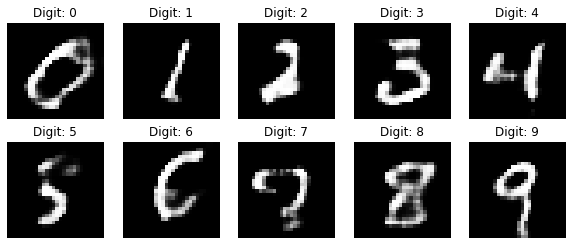

11000 [D loss: -0.0602, acc.: 50.00%] [G loss: -1.9393, mae.: 0.21], in: 0.38 seconds.


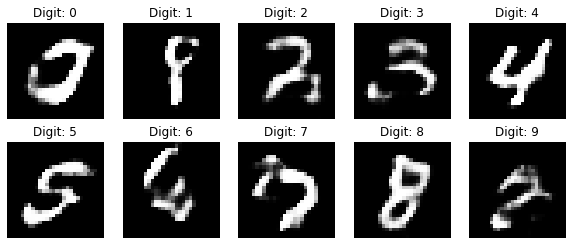

12000 [D loss: -0.0310, acc.: 50.00%] [G loss: -1.8635, mae.: 0.26], in: 0.43 seconds.


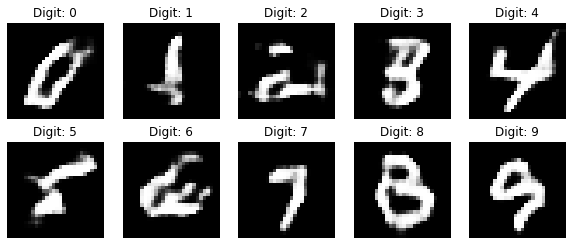

13000 [D loss: -0.0593, acc.: 50.00%] [G loss: -1.8674, mae.: 0.27], in: 0.40 seconds.


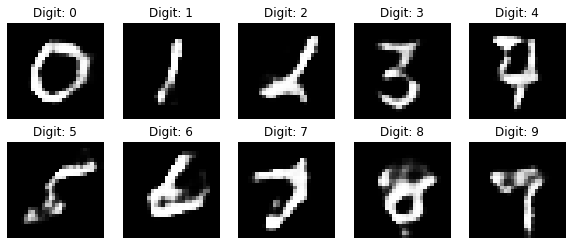

14000 [D loss: -0.0248, acc.: 50.00%] [G loss: -1.6932, mae.: 0.23], in: 0.40 seconds.


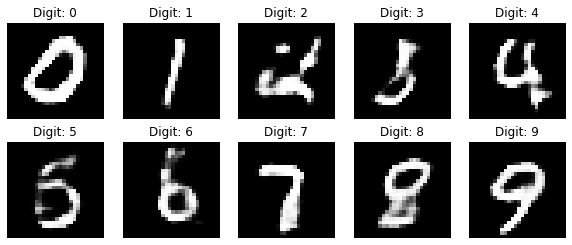

15000 [D loss: -0.0597, acc.: 50.00%] [G loss: -1.7681, mae.: 0.23], in: 0.42 seconds.


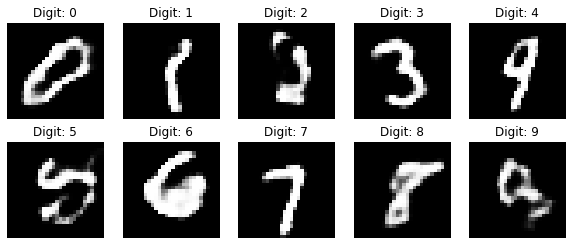

16000 [D loss: 0.0245, acc.: 50.00%] [G loss: -1.6679, mae.: 0.25], in: 0.44 seconds.


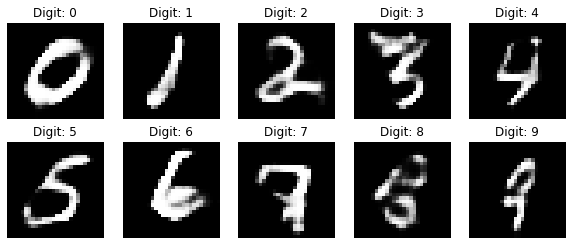

17000 [D loss: -0.0437, acc.: 50.00%] [G loss: -1.6657, mae.: 0.22], in: 0.43 seconds.


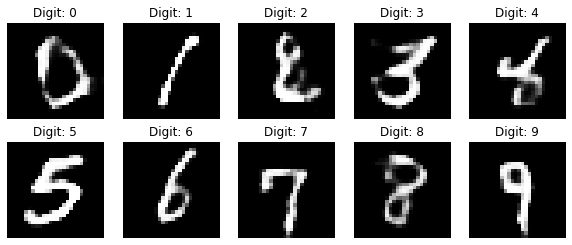

18000 [D loss: 0.0137, acc.: 50.00%] [G loss: -1.5965, mae.: 0.24], in: 0.46 seconds.


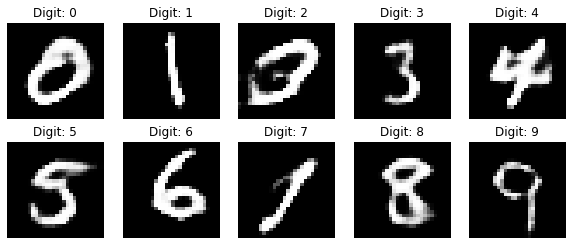

19000 [D loss: 0.0085, acc.: 50.00%] [G loss: -1.5189, mae.: 0.25], in: 0.41 seconds.


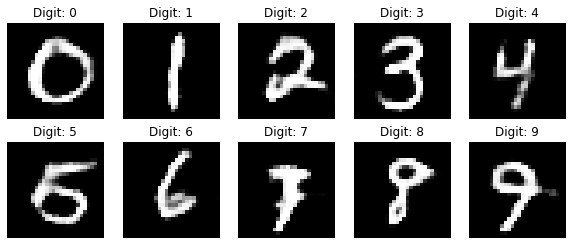

20000 [D loss: -0.0337, acc.: 50.00%] [G loss: -1.4993, mae.: 0.23], in: 0.40 seconds.


In [ ]:
# Set some hyperparameters
params = {
    'n_epochs': 20000,
    'batch_size': 64,
    'sample_interval': 1000,
    'z_dim': z_dim,
    'n_classes': n_classes
}

# Train the CGAN for the specified number of iterations
losses, accuracies = train(x_train, y_train, params)

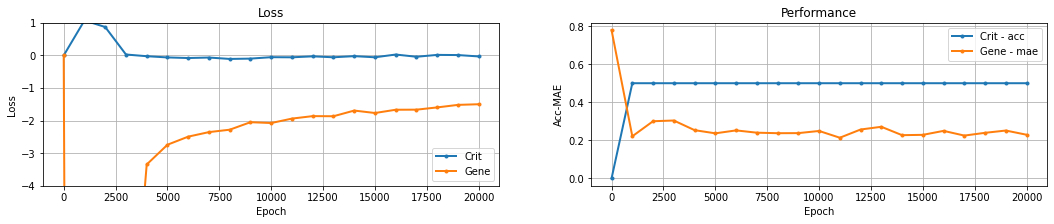

In [ ]:
# Plot loss
losses = np.array(losses)
accuracies = np.array(accuracies)

plt.figure(figsize=(18, 3))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(range(1, params['n_epochs']+2, params['sample_interval']), losses[:, 0], label='Crit', marker='.', linewidth=2)
plt.plot(range(1, params['n_epochs']+2, params['sample_interval']), losses[:, 1], label='Gene', marker='.', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim((-4, 1))
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Performance')
plt.plot(range(1, params['n_epochs']+2, params['sample_interval']), accuracies[:, 0], label='Crit - acc', marker='.', linewidth=2)
plt.plot(range(1, params['n_epochs']+2, params['sample_interval']), accuracies[:, 1], label='Gene - mae', marker='.', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Acc-MAE')
plt.grid(True)

plt.show()